<a href="https://colab.research.google.com/github/Kryptera-K/GLD-Golden-KC-Ulcer-Reversal-Strategy/blob/main/GLD_D1_%5B'KC_Open_Above_Lower'_'UI_Down_is_Rising'%5D_%5B'ROC_Cross_Above_Level'_'OSMA_Falling'%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Parameters
# -------------------------
symbol = "GLD"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Keltner Channel Calculation
# -------------------------
kc_period = 20
kc_multiplier = 2
df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
df['KC_Mid'] = df['TP'].ewm(span=kc_period, adjust=False).mean()
df['H-L'] = df['High'] - df['Low']
df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
df['ATR'] = df['TR'].rolling(kc_period).mean()
df['KC_Lower'] = df['KC_Mid'] - kc_multiplier * df['ATR']

# Entry Condition 1: Open above KC Lower
df['KC_Open_Above_Lower'] = df['Open'] > df['KC_Lower']

# -------------------------
# Ulcer Index Down
# -------------------------
lookback = 14
UI_shift = 5
df['RollingMax'] = df['Close'].cummax()
drawdown_pct = (df['Close'] - df['RollingMax']) / df['RollingMax'] * 100
df['UI_Down'] = drawdown_pct.rolling(lookback).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)

# Entry Condition 2: UI Down is Rising
df['UI_Down_is_Rising'] = df['UI_Down'] > df['UI_Down'].shift(UI_shift)

# -------------------------
# ROC Calculation
# -------------------------
roc_period = 10
roc_level = 0
df['ROC'] = (df['Close'] - df['Close'].shift(roc_period)) / df['Close'].shift(roc_period) * 100

# Exit Condition 1: ROC Cross Above Level
df['ROC_Cross_Above_Level'] = (df['ROC'].shift(1) <= roc_level) & (df['ROC'] > roc_level)

# -------------------------
# OSMA Calculation
# -------------------------
fast, slow, signal_period = 12, 26, 9
osma_shift = 5
df['EMA_fast'] = df['Close'].ewm(span=fast, adjust=False).mean()
df['EMA_slow'] = df['Close'].ewm(span=slow, adjust=False).mean()
df['MACD'] = df['EMA_fast'] - df['EMA_slow']
df['Signal'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()
df['OSMA'] = df['MACD'] - df['Signal']

# Exit Condition 2: OSMA Falling
df['OSMA_Falling'] = df['OSMA'] < df['OSMA'].shift(osma_shift)

# -------------------------
# Entry / Exit Signals
# -------------------------
entry_conditions = ['KC_Open_Above_Lower', 'UI_Down_is_Rising']
exit_conditions  = ['ROC_Cross_Above_Level', 'OSMA_Falling']

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------
entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

print(pf.stats())
pf.plot().show()


/tmp/ipython-input-678081630.py:17: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Start                                2004-11-18 00:00:00
End                                  2025-09-26 00:00:00
Period                                5247 days 00:00:00
Start Value                                     100000.0
End Value                                 1016948.758108
Total Return [%]                              916.948758
Benchmark Return [%]                          678.370435
Max Gross Exposure [%]                             100.0
Total Fees Paid                             39325.010007
Max Drawdown [%]                                43.91908
Max Drawdown Duration                 2163 days 00:00:00
Total Trades                                          53
Total Closed Trades                                   52
Total Open Trades                                      1
Open Trade PnL                             132031.017685
Win Rate [%]                                   67.307692
Best Trade [%]                                 70.135701
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2004-11-18 00:00:00
End                           2025-09-26 00:00:00
Period                         5247 days 00:00:00
Start Value                              100000.0
End Value                           778370.434834
Total Return [%]                       678.370435
Benchmark Return [%]                   678.370435
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        45.324522
Max Drawdown Duration          2240 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      678370.434834
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


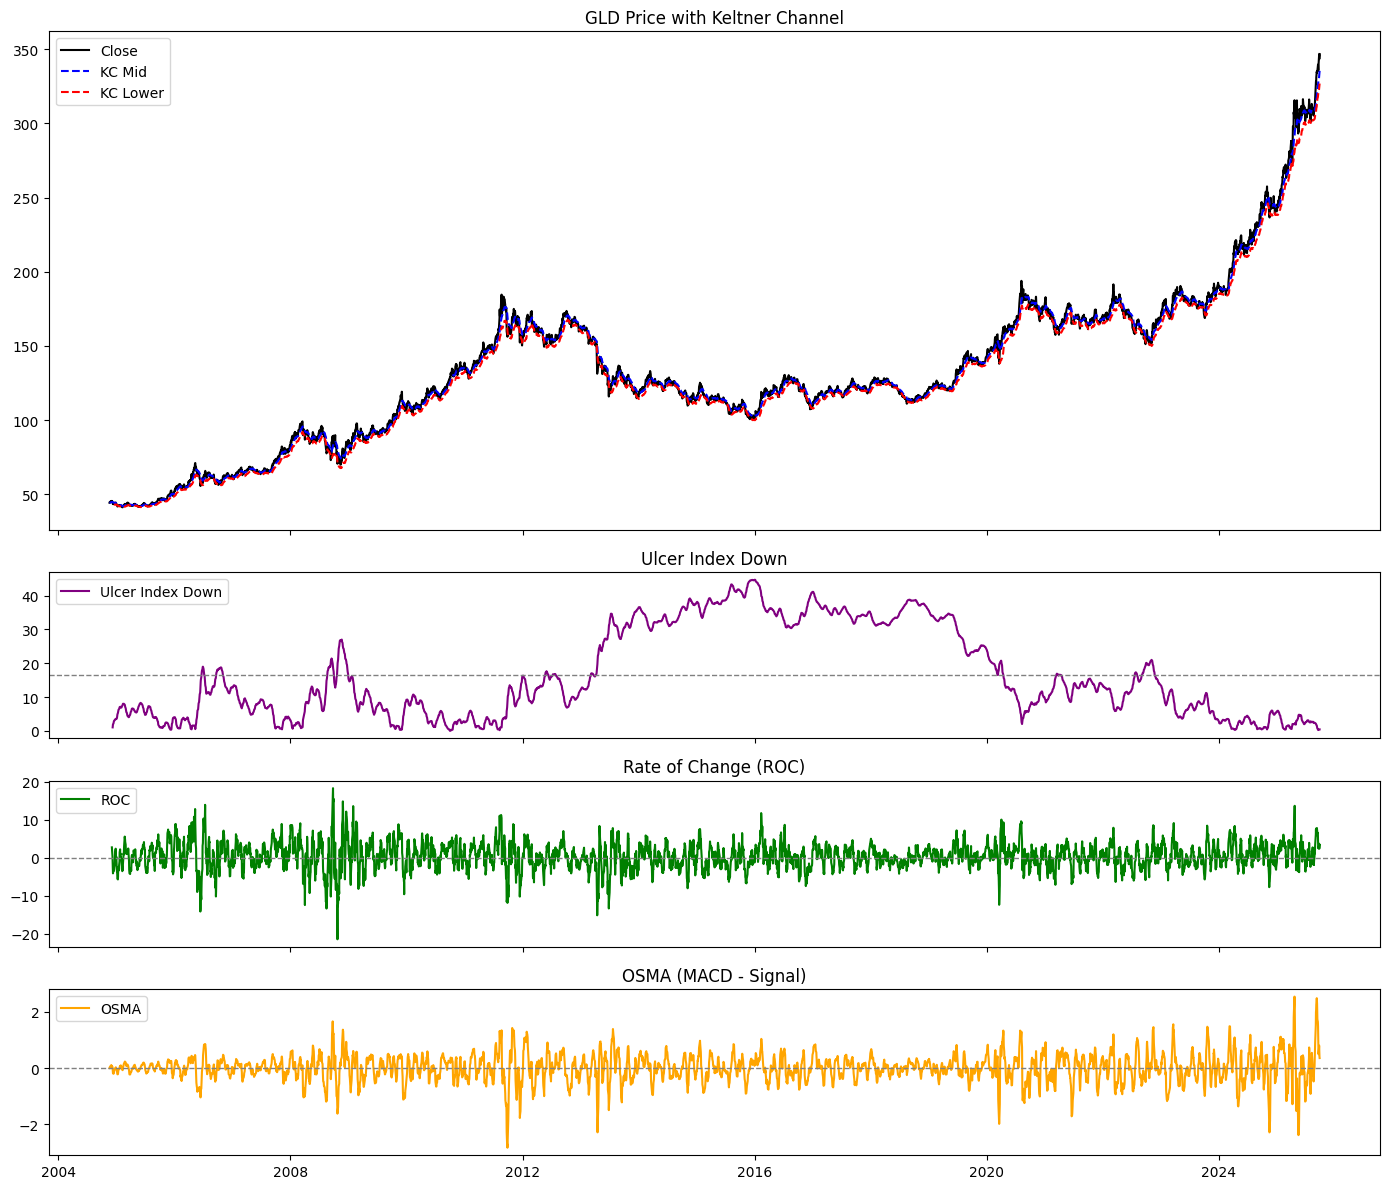

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# Plot All Indicators
# -------------------------
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

# --- 1. Price + Keltner Channel ---
axes[0].plot(df.index, df['Close'], label='Close', color='black')
axes[0].plot(df.index, df['KC_Mid'], label='KC Mid', linestyle='--', color='blue')
axes[0].plot(df.index, df['KC_Lower'], label='KC Lower', linestyle='--', color='red')
axes[0].set_title(f"{symbol} Price with Keltner Channel")
axes[0].legend(loc='upper left')

# --- 2. Ulcer Index Down ---
axes[1].plot(df.index, df['UI_Down'], label='Ulcer Index Down', color='purple')
axes[1].axhline(y=df['UI_Down'].mean(), color='gray', linestyle='--', linewidth=1)
axes[1].set_title("Ulcer Index Down")
axes[1].legend(loc='upper left')

# --- 3. ROC ---
axes[2].plot(df.index, df['ROC'], label='ROC', color='green')
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1)
axes[2].set_title("Rate of Change (ROC)")
axes[2].legend(loc='upper left')

# --- 4. OSMA ---
axes[3].plot(df.index, df['OSMA'], label='OSMA', color='orange')
axes[3].axhline(y=0, color='gray', linestyle='--', linewidth=1)
axes[3].set_title("OSMA (MACD - Signal)")
axes[3].legend(loc='upper left')

# --- Layout ---
plt.tight_layout()
plt.show()
